This project is based on the course content and sample code of Practical Deep Learning for Coders v3 from fast.ai. Following the course requirements, I performed Titanic survival prediction using the Kaggle platform. I would like to express my gratitude to Jeremy Howard and the fast.ai team.

Original course link: https://course.fast.ai/
Sample code link: https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson1-pets.ipynb

In [77]:
import fastai
print("Fastai version : " + fastai.__version__)

Fastai version : 2.5.3


In [78]:
import pandas as pd
import numpy as np


from fastai import *
from fastai.tabular.all import *


import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import Markdown, display
pd.options.mode.chained_assignment = None  # default='warn'

In [79]:
test = pd.read_csv('/kaggle/input/titanic/test.csv')
train = pd.read_csv('../input/titanic/train.csv')

print(f"train shape: {train.shape} | test shape: {test.shape}")

train shape: (891, 12) | test shape: (418, 11)


In [80]:
print("% Null distribution")
(train.isnull().sum()*100/train.shape[0]).sort_values(ascending = False).to_frame().T

% Null distribution


,Cabin,Age,Embarked,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare
0,77.104377,19.86532,0.224467,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [81]:
print("# Uniques")
display(train.nunique().sort_values(ascending = False).to_frame().T)

# Uniques


,PassengerId,Name,Ticket,Fare,Cabin,Age,SibSp,Parch,Pclass,Embarked,Survived,Sex
0,891,891,681,248,147,88,7,7,3,3,2,2


In [82]:
test_ext = pd.read_csv('/kaggle/input/titanic-extended/test.csv')
train_ext = pd.read_csv('../input/titanic-extended/train.csv')


print(f"train extended shape: {train_ext.shape} | test extended shape: {test_ext.shape}")

train extended shape: (891, 21) | test extended shape: (418, 20)


In [83]:
print("% Null distribution")
display((train_ext.isnull().sum()*100/train.shape[0]).sort_values(ascending = False).to_frame().T)

% Null distribution


,Body,Cabin,Lifeboat,Age,Age_wiki,Embarked,Destination,Boarded,Hometown,Name_wiki,...,Class,Survived,Fare,Ticket,Parch,SibSp,Sex,Name,Pclass,PassengerId
0,90.23569,77.104377,61.279461,19.86532,0.448934,0.224467,0.224467,0.224467,0.224467,0.224467,...,0.224467,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [84]:
print("# Uniques")
display(train_ext.nunique().sort_values(ascending = False).to_frame().T)

# Uniques


,PassengerId,Name,Name_wiki,WikiId,Ticket,Hometown,Fare,Destination,Cabin,Age,...,Age_wiki,Lifeboat,Parch,SibSp,Boarded,Embarked,Pclass,Class,Survived,Sex
0,891,891,889,889,681,437,248,234,147,88,...,74,22,7,7,4,3,3,3,2,2


In [85]:
req_cols = train_ext.columns.difference(['Body','Cabin' # high null features
                                         ,'Age','Class','Name','Embarked'# duplicate features
                                         ,'PassengerId','Name_wiki','WikiId'] # high cardinality features
                                       ).tolist()
print("Required features :", req_cols)

Required features : ['Age_wiki', 'Boarded', 'Destination', 'Fare', 'Hometown', 'Lifeboat', 'Parch', 'Pclass', 'Sex', 'SibSp', 'Survived', 'Ticket']


In [86]:
# filtering train and test on required columns
train_ext_fltr = train_ext[req_cols]
test_ext_fltr = test_ext[[col for col in req_cols if col != "Survived"]]

In [87]:
# categorical features
cat_feat = train_ext_fltr.select_dtypes("O").columns.tolist()

# continuos features
cont_feat = train_ext_fltr.columns.difference(cat_feat+["Survived"]).tolist()

In [88]:
print("categorical data:")
display(train_ext_fltr[cat_feat].head(2))


print("continuos data:")
display(train_ext_fltr[cont_feat].head(2))

categorical data:


,Boarded,Destination,Hometown,Lifeboat,Sex,Ticket
0,Southampton,"Qu'Appelle Valley, Saskatchewan, Canada","Bridgerule, Devon, England",NaN,male,A/5 21171
1,Cherbourg,"New York, New York, US","New York, New York, US",4,female,PC 17599


continuos data:


,Age_wiki,Fare,Parch,Pclass,SibSp
0,22.0,7.2500,0,3,1
1,35.0,71.2833,0,1,1


In [89]:
print("% Null distribution")
display((train_ext_fltr.isnull().sum()*100/train_ext_fltr.shape[0]).sort_values(ascending = False).to_frame().T)

% Null distribution


,Lifeboat,Age_wiki,Boarded,Destination,Hometown,Fare,Parch,Pclass,Sex,SibSp,Survived,Ticket
0,61.279461,0.448934,0.224467,0.224467,0.224467,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [90]:
# splitting criteria - random split with 20% in validation set
splits = RandomSplitter(valid_pct=0.2, seed=1000)(range_of(train_ext_fltr))

tp = TabularPandas(train_ext_fltr, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cat_feat,
                   cont_names = cont_feat,
                   y_names='Survived',
                   y_block=CategoryBlock(),
                   splits=splits)

In [91]:
tp.show(max_n=3)

,Boarded,Destination,Hometown,Lifeboat,Sex,Ticket,Age_wiki_na,Age_wiki,Fare,Parch,Pclass,SibSp,Survived
299,Cherbourg,"Montreal, Quebec, Canada","Montreal, Quebec, Canada",6,female,PC 17558,False,50.0,247.520798,1.0,1.0,0.0,1.0
438,Southampton,"Winnipeg, Manitoba, Canada","Winnipeg, Manitoba, Canada",#na#,male,19950,False,64.0,263.000000,4.0,1.0,1.0,0.0
815,Southampton,"New York, New York, US","Liverpool, Merseyside, England, UK",#na#,male,112058,False,39.0,0.000000,0.0,1.0,0.0,0.0


In [92]:
print("filling strategy:",tp.fill_strategy)

filling strategy: median


In [93]:
# we can see `_na` are added to cat_feat list
print("we can see that corresponding  _na (bool) features have been added wherever the columns have nulls")
print([col for col in cat_feat if  "_na" in col])

we can see that corresponding  _na (bool) features have been added wherever the columns have nulls
['Age_wiki_na']


In [94]:
# normalize transform
norms = tp.procs.normalize

In [95]:
print("Mean/STD for each continuos col")
cont_col_stat = pd.DataFrame([norms.means, norms.stds], index = ["mean","std"])
cont_col_stat

Mean/STD for each continuos col


,Age_wiki,Fare,Parch,Pclass,SibSp
mean,29.070477,32.603092,0.366059,2.311360,0.544180
std,13.689388,51.154633,0.761502,0.833114,1.154817


In [96]:
# At index = 299 the value for Age_wiki is 1.528887
tp.conts.head(1)

,Age_wiki,Fare,Parch,Pclass,SibSp
299,1.528887,4.201334,0.832487,-1.574047,-0.471226


In [97]:
# Mean & Std for Age feature
age_mean = cont_col_stat["Age_wiki"]["mean"]
age_std = cont_col_stat["Age_wiki"]["std"]

# standardizing age_wiki for 299 index
age_index_299 = train_ext_fltr.loc[299,"Age_wiki"]
age_std = (age_index_299 - age_mean)/age_std

print("Standard Age_wiki using (X-Xmean/Xstd) : ",age_std)

Standard Age_wiki using (X-Xmean/Xstd) :  1.5288866744416272


- **Another fun thing!**
    - Can someone tell me why aren't the calculated normalizing means matching when we are calculating means manually ?? `Its easy`

In [98]:
print("means calculated for normalizing")
display(cont_col_stat.iloc[0].to_frame().T)

print()

print("means calc manually")
display(train_ext[cont_feat].mean().to_frame().T)

means calculated for normalizing


,Age_wiki,Fare,Parch,Pclass,SibSp
mean,29.070477,32.603092,0.366059,2.31136,0.54418



means calc manually


,Age_wiki,Fare,Parch,Pclass,SibSp
0,29.322063,32.204208,0.381594,2.308642,0.523008


- `Hint`

```
t1 = train_ext_fltr.iloc[tp.train.xs.index.tolist()].Age_wiki
t1.fillna(t1.median()).mean()
```

In [99]:
print("lets look at how label-encodings are done for categorical data \n")
label_encoding_dict = {cat : tp.procs.categorify[cat].o2i for cat in tp.cat_names}


print("label encodings for 'boarded' variable")
label_encoding_dict['Boarded']

lets look at how label-encodings are done for categorical data 

label encodings for 'boarded' variable


defaultdict(int,
            {'#na#': 0,
             'Belfast': 1,
             'Cherbourg': 2,
             'Queenstown': 3,
             'Southampton': 4})

- Lets look at how a row at `index 0` in the data is `label-encoded`, use below code
- You can see that the `Boarded` variable for value `Cherbourg` is encoded as `2` which can be verified in the above encodings

In [100]:
print("encoded data")
display(tp.items.iloc[[0]])

print()

print("original data - categorical values")
row = tp.items.iloc[0]
tp.decode_row(row).to_frame().T

encoded data


,Age_wiki,Boarded,Destination,Fare,Hometown,Lifeboat,Parch,Pclass,Sex,SibSp,Survived,Ticket,Age_wiki_na
299,1.528887,2,139,4.201334,268,14,0.832487,-1.574047,1,-0.471226,1,586,1



original data - categorical values


,Age_wiki,Boarded,Destination,Fare,Hometown,Lifeboat,Parch,Pclass,Sex,SibSp,Survived,Ticket,Age_wiki_na
299,50.0,Cherbourg,"Montreal, Quebec, Canada",247.520798,"Montreal, Quebec, Canada",6,1.0,1.0,female,0.0,1.0,PC 17558,False


In [101]:
emb_szs = get_emb_sz(tp)

print("Embedding size associated with each categorical feature:\n")
print({k:v for k,v in zip(tp.cat_names,emb_szs)})

Embedding size associated with each categorical feature:

{'Boarded': (5, 4), 'Destination': (235, 34), 'Hometown': (438, 48), 'Lifeboat': (23, 9), 'Sex': (3, 3), 'Ticket': (682, 62), 'Age_wiki_na': (3, 3)}


**Okay, so ideally the first param should follow `embedding_size == # unique categories`**

    
    Ref : https://forums.fast.ai/t/size-of-matrix-in-colab-learner-not-matching/72017/6

In [102]:
print("# uniques in categorical features")
tp[cat_feat].nunique().to_frame().T

# uniques in categorical features


,Boarded,Destination,Hometown,Lifeboat,Sex,Ticket,Age_wiki_na
0,5,235,438,23,2,681,2


In [103]:
# creating TabDataloaders
trn_dl = TabDataLoader(tp.train, bs=64, shuffle=True, drop_last=True)
val_dl = TabDataLoader(tp.valid, bs=64)

- **`Dataloaders`**

In [104]:
# creating dataloaders
dls = DataLoaders(trn_dl, val_dl)

In [105]:
print("Dataloaders is just combining the train and validation TabDataloader")
print(dls.train == trn_dl)

Dataloaders is just combining the train and validation TabDataloader
True


In [106]:
# lets build the NN with 2 layer - [30, 10 Neurons]
learn = tabular_learner(dls, layers=[30,10], metrics=accuracy)

In [107]:
# model architecture
learn.summary()

TabularModel (Input shape: 64 x 7)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 4              
Embedding                                 20         True      
____________________________________________________________________________
                     64 x 34             
Embedding                                 7990       True      
____________________________________________________________________________
                     64 x 48             
Embedding                                 21024      True      
____________________________________________________________________________
                     64 x 9              
Embedding                                 207        True      
____________________________________________________________________________
                     64 x 3              
Embedding                                 9          True      
_______________________________________________________________

In [108]:
print("size of embeddings")
print(learn.embeds)

size of embeddings
ModuleList(
  (0): Embedding(5, 4)
  (1): Embedding(235, 34)
  (2): Embedding(438, 48)
  (3): Embedding(23, 9)
  (4): Embedding(3, 3)
  (5): Embedding(682, 62)
  (6): Embedding(3, 3)
)


SuggestedLRs(valley=0.005248074419796467)

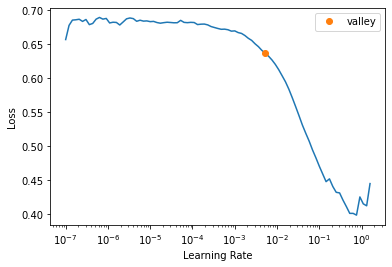

In [109]:
learn.lr_find()

In [110]:
learn.fit_one_cycle(10, lr_max = 5e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.576518,0.622710,0.662921,00:00
1,0.327723,0.109695,0.971910,00:00
2,0.196204,0.066987,0.977528,00:00
3,0.143007,0.062576,0.971910,00:00
4,0.104399,0.049065,0.977528,00:00
5,0.078140,0.011892,0.994382,00:00
6,0.058749,0.000993,1.000000,00:00
7,0.044802,0.001529,1.000000,00:00
8,0.035117,0.001726,1.000000,00:00
9,0.027397,0.001590,1.000000,00:00


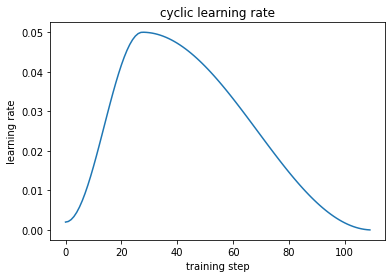

In [111]:
plt.title("cyclic learning rate")
plt.xlabel("training step")
plt.ylabel("learning rate")
plt.plot(range(len(learn.recorder.lrs)),learn.recorder.lrs)

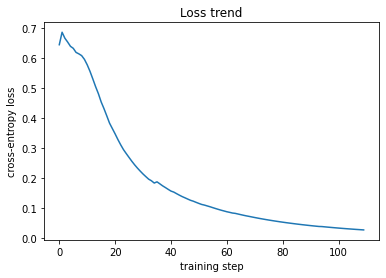

In [112]:
plt.title("Loss trend")
plt.xlabel("training step")
plt.ylabel("cross-entropy loss")
plt.plot(range(len(learn.recorder.losses)),learn.recorder.losses)

In [113]:
# checking validation results
learn.recorder.show_results(max_n = 3)

,Boarded,Destination,Hometown,Lifeboat,Sex,Ticket,Age_wiki_na,Age_wiki,Fare,Parch,Pclass,SibSp,Survived,Survived_pred
0,2.0,149.0,278.0,0.0,2.0,601.0,1.0,-0.078198,0.968978,-0.480706,-1.574047,0.394712,0.0,0.0
1,2.0,228.0,167.0,0.0,2.0,178.0,1.0,1.163640,-0.496105,-0.480706,0.826585,-0.471226,0.0,0.0
2,4.0,108.0,225.0,0.0,2.0,328.0,1.0,-0.954789,-0.485354,-0.480706,0.826585,-0.471226,0.0,0.0


In [114]:
print("This is how the model's architecture looks! \n")
learn.model

This is how the model's architecture looks! 



TabularModel(
  (embeds): ModuleList(
    (0): Embedding(5, 4)
    (1): Embedding(235, 34)
    (2): Embedding(438, 48)
    (3): Embedding(23, 9)
    (4): Embedding(3, 3)
    (5): Embedding(682, 62)
    (6): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=168, out_features=30, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=30, out_features=10, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=10, out_features=2, bias=True)
    )
  )
)

<a id="assert"></a> 
- `Assert if N_cont + N_cat_embed == 168`

In [115]:
concat_embed_size = sum([x.weight.shape[1] for x in learn.embeds])  # 163 size
n_cont_feat = 5 # continuos data

print("total size of concatenated categorical embeddings and continuos features equals ::",  concat_embed_size + n_cont_feat)

total size of concatenated categorical embeddings and continuos features equals :: 168


In [116]:
# imputing fare with median (coz training data did not have any missings for Fare)
fare_med_val = test_ext_fltr.Fare.median()
test_ext_fltr.loc[:,'Fare'].fillna(fare_med_val, inplace = True)

In [117]:
t1 = learn.dls.train_ds.new(test_ext_fltr)
t1.process()

dl = TabDataLoader(t1)
preds = learn.get_preds(dl=dl)[0].argmax(1).numpy()

In [118]:
out = pd.DataFrame({'PassengerId':test_ext.PassengerId, 'Survived': preds.astype(int)})
out.to_csv('submission_1.csv', index=False)
out.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
